In [3]:
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [4]:
print("TensorFlow:", tf.__version__)

TensorFlow: 2.11.0


In [5]:
vocab_size = 10000
maxlen = 200  # sequence length (pad/cut reviews to this length)


In [6]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)


In [7]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test  = pad_sequences(x_test,  maxlen=maxlen)

In [8]:
print("Train shape:", x_train.shape, "Test shape:", x_test.shape)


Train shape: (25000, 200) Test shape: (25000, 200)


In [9]:
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen),
    layers.SimpleRNN(64, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
313/313 [==============================] - 33s 91ms/step - loss: 0.6126 - accuracy: 0.6440 - val_loss: 0.4188 - val_accuracy: 0.8196
Epoch 2/5
313/313 [==============================] - 27s 85ms/step - loss: 0.3897 - accuracy: 0.8339 - val_loss: 0.4344 - val_accuracy: 0.8270
Epoch 3/5
313/313 [==============================] - 26s 83ms/step - loss: 0.4215 - accuracy: 0.8159 - val_loss: 0.4590 - val_accuracy: 0.7980
Epoch 4/5
313/313 [==============================] - 27s 86ms/step - loss: 0.3006 - accuracy: 0.8758 - val_loss: 0.5985 - val_accuracy: 0.6688
Epoch 5/5
313/313 [==============================] - 26s 85ms/step - loss: 0.2772 - accuracy: 0.8884 - val_loss: 0.4378 - val_accuracy: 0.8390


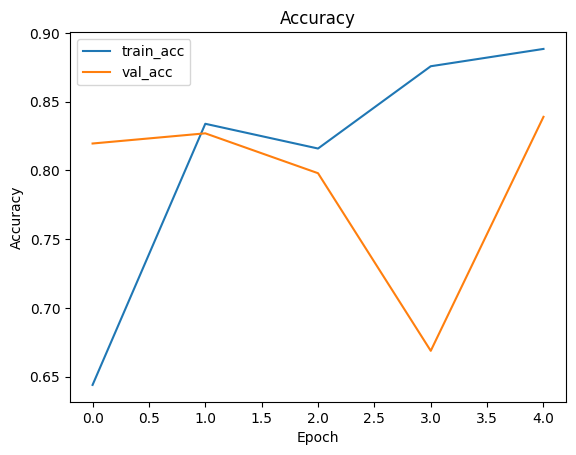

In [12]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

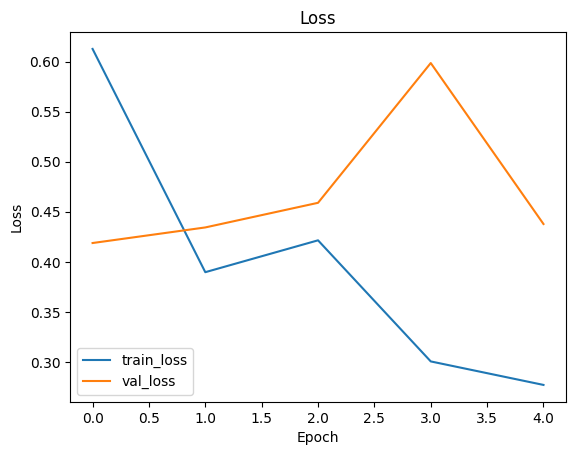

In [13]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss    : {test_loss:.4f}")



Test Accuracy: 0.8336
Test Loss    : 0.4484


In [15]:
y_prob = model.predict(x_test, verbose=0).reshape(-1)
y_pred = (y_prob >= 0.5).astype(int)

In [16]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative (0)", "Positive (1)"]))



Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.83      0.83      0.83     12500
Positive (1)       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [17]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)



Confusion Matrix:
 [[10420  2080]
 [ 2079 10421]]


In [18]:
word_index = imdb.get_word_index()

# Keras IMDB uses reserved indices:
# 0: padding, 1: start_of_sequence, 2: unknown, 3: unused
INDEX_FROM = 3

1641221/1641221 [==============================] - 0s 0us/step


In [19]:
def encode_review(raw_text, maxlen=maxlen):
    # Basic clean: lowercase & keep words
    text = raw_text.lower()
    # Split on non-letters to get tokens
    tokens = re.findall(r"[a-z']+", text)

    # Map tokens to indices (with +INDEX_FROM); unknown->2
    seq = []
    for w in tokens:
        idx = word_index.get(w, None)
        if idx is not None and (idx + INDEX_FROM) < vocab_size:
            seq.append(idx + INDEX_FROM)
        else:
            seq.append(2)  # unknown token

    # Optionally prepend start-of-sequence token 1
    seq = [1] + seq
    # Pad to required length
    return pad_sequences([seq], maxlen=maxlen)[0]

def predict_sentiment(raw_text):
    seq = encode_review(raw_text)
    prob = float(model.predict(np.array([seq]), verbose=0)[0][0])
    label = 1 if prob >= 0.5 else 0
    return label, prob


In [20]:
samples = [
    "The movie was amazing and I loved it!",
    "This was a terrible film. I hated every minute.",
    "Not bad, but could have been better.",
]

for s in samples:
    label, prob = predict_sentiment(s)
    print(f"\nText: {s}\nPredicted: {'Positive (1)' if label==1 else 'Negative (0)'} | Probability={prob:.3f}")

# ---- Optional: Inspect a few test predictions vs actual ----
print("\nSample Predictions vs Actual (first 10):")
sample_probs = model.predict(x_test[:10], verbose=0).reshape(-1)
sample_pred = (sample_probs >= 0.5).astype(int)
print("Pred :", sample_pred.tolist())
print("Actual:", y_test[:10].tolist())


Text: The movie was amazing and I loved it!
Predicted: Positive (1) | Probability=0.993

Text: This was a terrible film. I hated every minute.
Predicted: Positive (1) | Probability=0.699

Text: Not bad, but could have been better.
Predicted: Negative (0) | Probability=0.451

Sample Predictions vs Actual (first 10):
Pred : [1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Actual: [0, 1, 1, 0, 1, 1, 1, 0, 0, 1]


In [21]:
predict_sentiment("i hate the movie")

(1, 0.9268682599067688)